# **Step 1: Setup and Load the Data**

We need to import the customer dataset (CC GENERAL.csv) into our notebook so we can start exploring, cleaning, and clustering. We'll also import all the necessary libraries to use throughout the project.

In [1]:
#  Install kagglehub if you haven’t already
!pip install kagglehub --quiet

#  Import necessary packages
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')


In [2]:
#  Download the dataset from Kaggle
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")

#  Load the dataset using the full path
df = pd.read_csv(f"{path}/CC GENERAL.csv")

#  Preview the first few rows
df.head()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# **Step 2: Data Preprocessing and Cleaning**
We remove unnecessary columns, handle missing values, and scale the data to prepare it for clustering.


In [3]:
# Drop the 'CUST_ID' column since it's just an identifier
df_cleaned = df.drop("CUST_ID", axis=1)

# Check for missing values
df_cleaned.isnull().sum()

,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,0


We see that 'MINIMUM_PAYMENTS' and 'CREDIT_LIMIT' contain missing values.


In [4]:
# Fill missing values with the median
df_cleaned.fillna(df_cleaned.median(), inplace=True)

# Confirm all missing values are handled
df_cleaned.isnull().sum().sum()


np.int64(0)

Now all missing values are filled. The dataset is clean.


In [5]:
# Standardize the data for clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cleaned)


# **Step 3: Exploratory Data Analysis (EDA)**

Before applying clustering algorithms, we explore the dataset to understand distributions, relationships, and potential patterns. This helps in interpreting clusters later and identifying features that may affect segmentation.


# 3.1: Summary Statistics

This gives you the min, max, mean, and standard deviation of each column to understand data spread.

In [6]:
# View summary statistics of the cleaned data
df_cleaned.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.282473,1733.143852,844.906767,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.646702,2895.063757,2332.792322,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,170.857654,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,788.713501,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


# 3.2: Distribution Plots

This shows how each variable is distributed (e.g., skewed, normal, outliers).

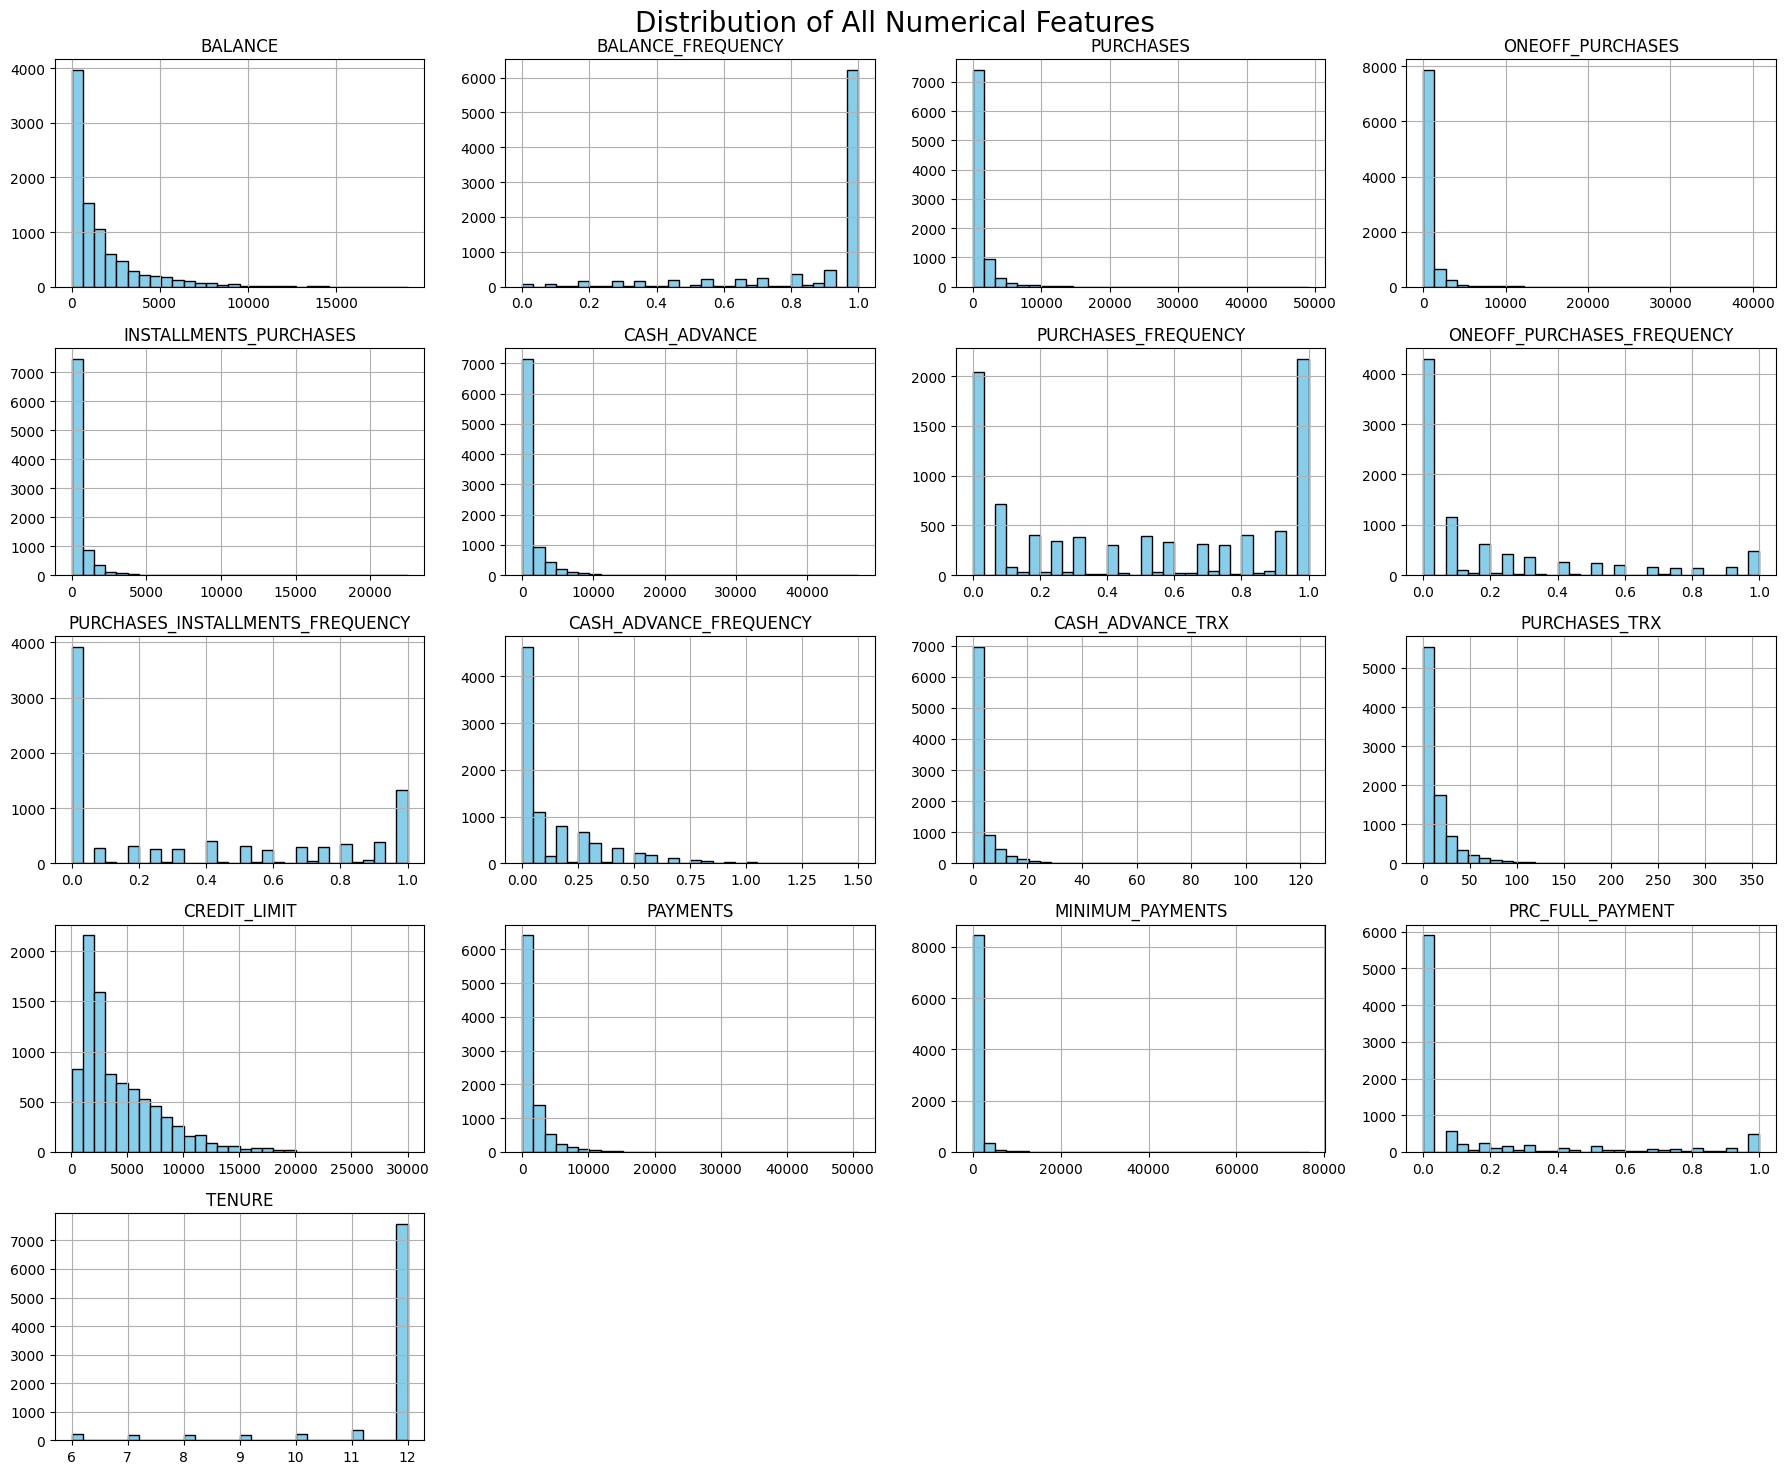

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for all features
df_cleaned.hist(figsize=(18, 15), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of All Numerical Features", fontsize=20)
plt.tight_layout()
plt.show()


# 3.3: Correlation Heatmap

Helps spot highly correlated features. For example, if two features are very similar, PCA may drop one.

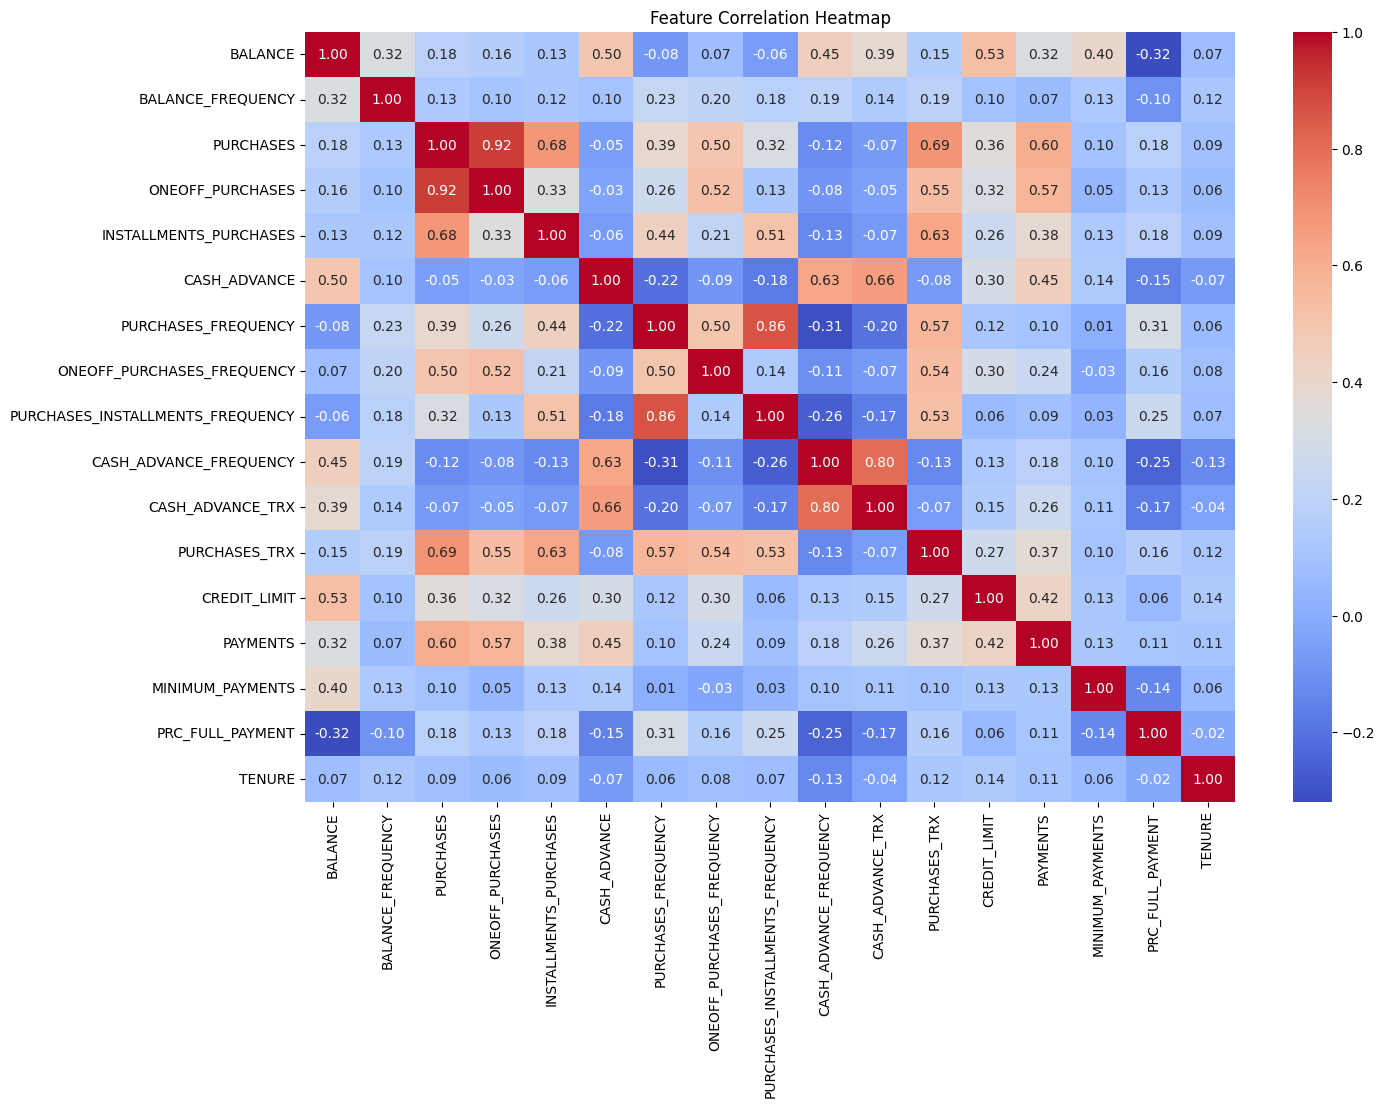

In [8]:
# Plot a heatmap of feature correlations
plt.figure(figsize=(15, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


# **Step 4: Apply Unsupervised Learning Algorithms (Clustering)**

Now that the data is cleaned and explored, we apply clustering algorithms to group similar customers. We’ll use:
*   K-Means
*   Agglomerative Hierarchical Clustering
*   DBSCAN

We’ll also determine how many clusters to use and reduce the data with PCA to visualize it in 2D and 3D.

# 4.1: Determine Optimal Clusters for K-Means (Elbow Method + Silhouette Score)

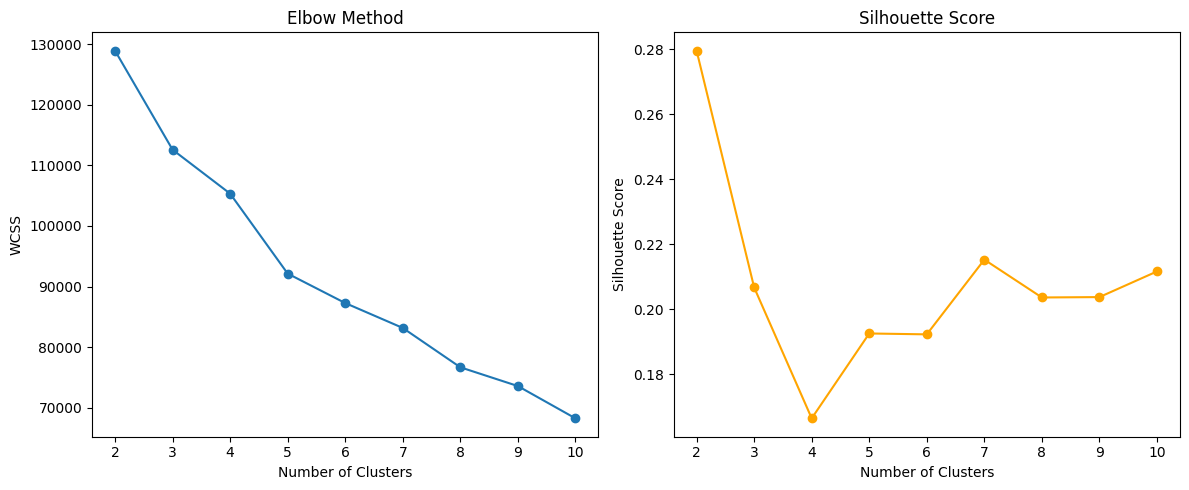

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


# 4.2: Apply K-Means Clustering

In [10]:
# Choose k based on previous plot (example: k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# 4.3: Agglomerative Hierarchical Clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering

# Let’s try 12 clusters (you can change it)
agglo = AgglomerativeClustering(n_clusters=12)
agglo_labels = agglo.fit_predict(scaled_data)


# 4.4: Use DBSCAN (Detect Outliers)

**Step 1: Estimate Good eps Using k-distance Graph**

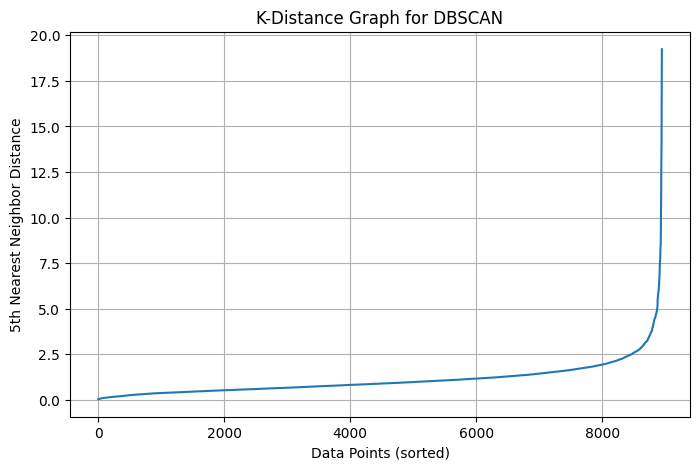

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

distances = np.sort(distances[:, 4])
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("K-Distance Graph for DBSCAN")
plt.xlabel("Data Points (sorted)")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


**Step 2: Apply DBSCAN**

In [13]:
from sklearn.cluster import DBSCAN

# Example: eps=2.5, min_samples=5 — adjust based on graph
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)


# 4.5: Dendrogram for Agglomerative Clustering

Before deciding the number of clusters in Agglomerative Clustering, the dendrogram shows how data points are hierarchically merged, and you can use the largest vertical gap (no horizontal line crossing) to determine the ideal number of clusters.

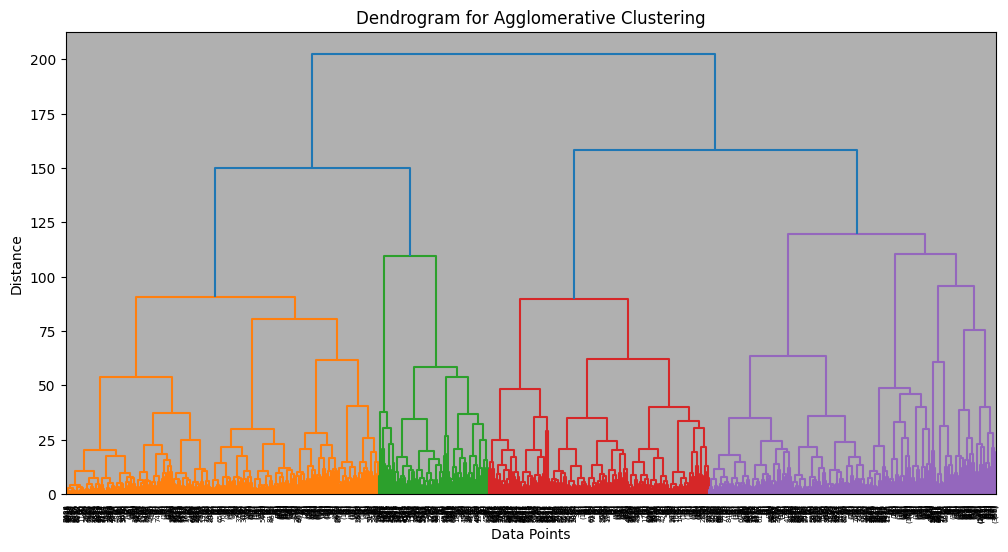

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Compute linkage matrix for dendrogram
linked = linkage(scaled_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=10)
plt.title("Dendrogram for Agglomerative Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


# **Step 5: Apply PCA for Visualization (2D & 3D)**

The dataset has many features (17+), which makes it hard to visualize clusters. PCA reduces the data to 2D or 3D while keeping the most important information, so we can see cluster separation and patterns clearly.

# 5.1: Apply PCA for 2D and 3D

In [15]:
from sklearn.decomposition import PCA
import pandas as pd

# Apply PCA to reduce to 3 principal components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['KMeans'] = kmeans_labels
pca_df['Agglomerative'] = agglo_labels
pca_df['DBSCAN'] = dbscan_labels



# 5.2: Visualize Clusters in 2D (PC1 vs PC2)

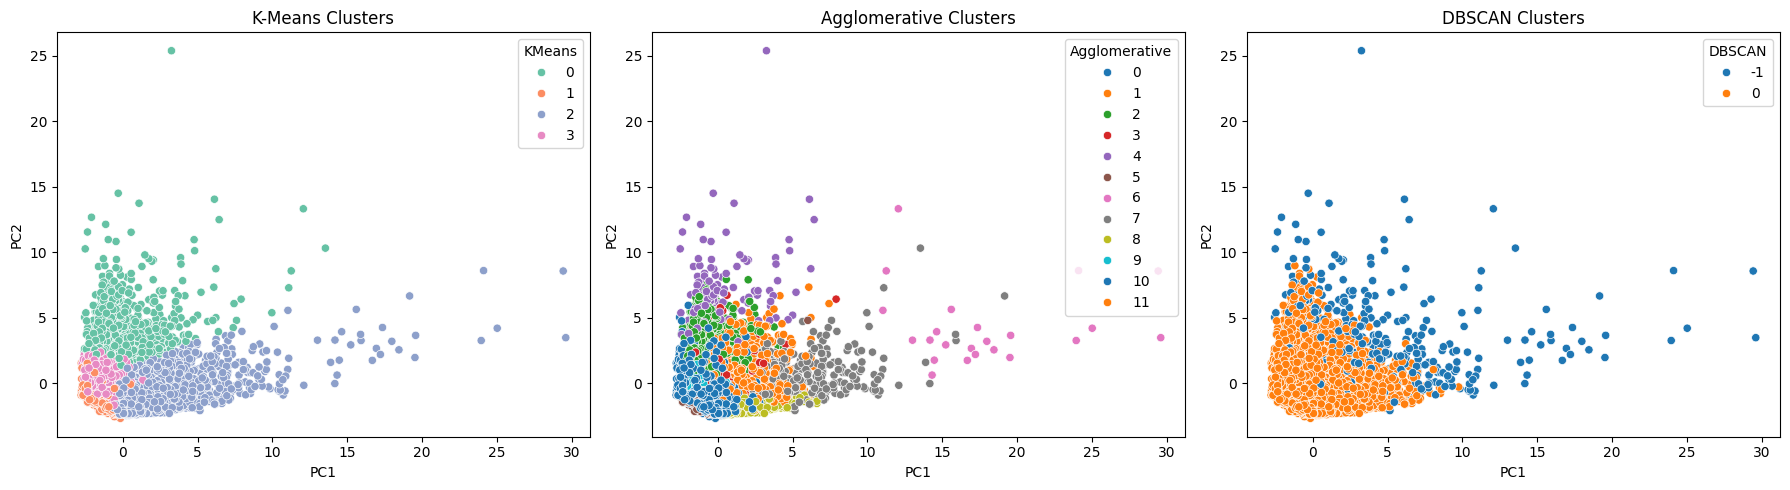

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# K-Means
plt.subplot(1, 3, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans', palette='Set2')
plt.title("K-Means Clusters")

# Agglomerative
plt.subplot(1, 3, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Agglomerative', palette='tab10')
plt.title("Agglomerative Clusters")

# DBSCAN
plt.subplot(1, 3, 3)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='DBSCAN', palette='tab10')
plt.title("DBSCAN Clusters")

plt.tight_layout()
plt.show()


# 5.3: Visualize Clusters in 3D

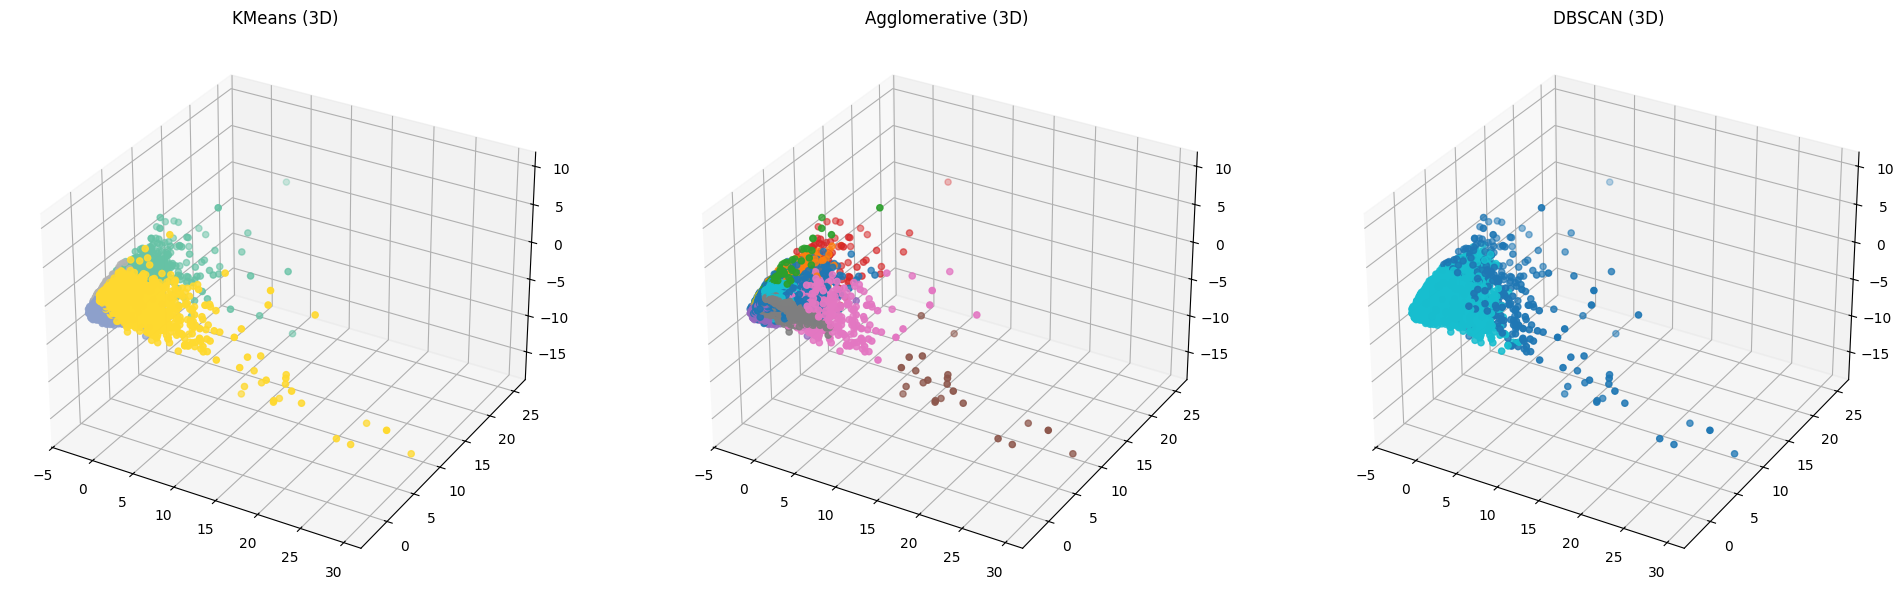

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 6))

# KMeans
ax = fig.add_subplot(131, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['KMeans'], cmap='Set2')
ax.set_title('KMeans (3D)')

# Agglomerative
ax = fig.add_subplot(132, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Agglomerative'], cmap='tab10')
ax.set_title('Agglomerative (3D)')

# DBSCAN
ax = fig.add_subplot(133, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['DBSCAN'], cmap='tab10')
ax.set_title('DBSCAN (3D)')

plt.tight_layout()
plt.show()


# **Step 6: Model Evaluation & Cluster Interpretation**

Clustering is unsupervised, so we don’t have ground truth labels. We evaluate how well the clustering worked using metrics like the Silhouette Score and visual cluster plots. Then we interpret what each group means — are they high spenders? Low credit users? Outliers?

# 6.1: Silhouette Score Comparison

Silhouette Score tells how well each point fits within its cluster:

*  > 0.5 → Good clustering (well separated)
*   0.3 to 0.5 → Moderate clustering (some overlap)
*   < 0.2 → Poor clustering (overlap, unclear groups)


In [18]:
from sklearn.metrics import silhouette_score

# KMeans
sil_kmeans = silhouette_score(scaled_data, kmeans_labels)

# Agglomerative
sil_agglo = silhouette_score(scaled_data, agglo_labels)

# DBSCAN (only calculate if more than 1 cluster)
sil_dbscan = silhouette_score(scaled_data, dbscan_labels) if len(set(dbscan_labels)) > 1 else None

print("Silhouette Scores:")
print(f"KMeans:        {sil_kmeans:.3f}")
print(f"Agglomerative: {sil_agglo:.3f}")
print(f"DBSCAN:        {sil_dbscan if sil_dbscan else 'N/A'}")


Silhouette Scores:
KMeans:        0.166
Agglomerative: 0.141
DBSCAN:        0.5677200519148109


# **Step 7: 3D PCA Visualization**

2D PCA is helpful, but may hide some cluster separation. 3D PCA gives a richer view of how clusters behave in space — especially for higher-dimensional data like this.

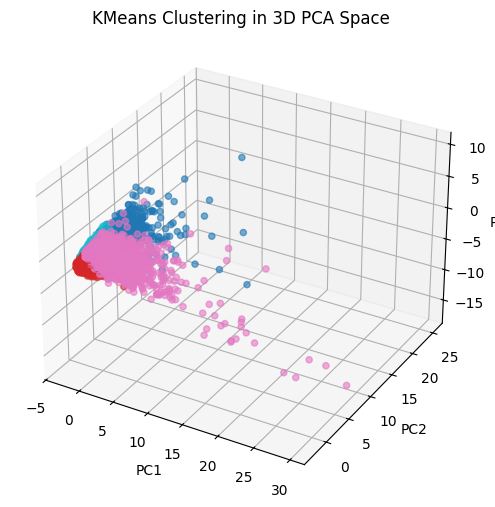

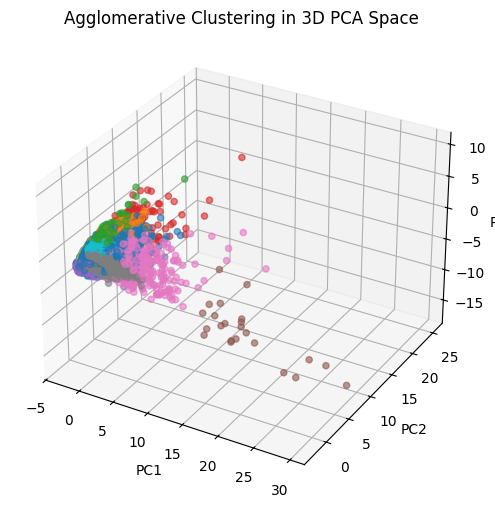

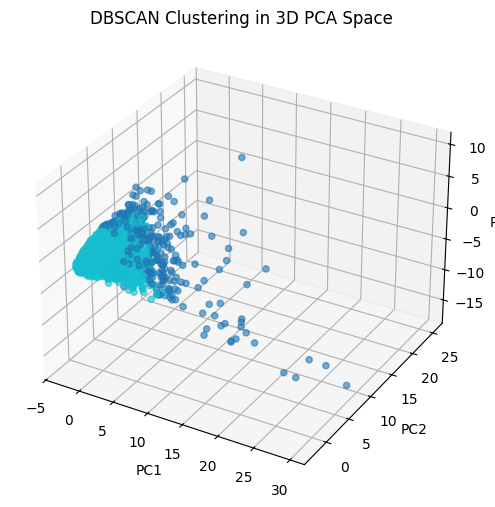

In [19]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Perform 3D PCA
pca_3d = PCA(n_components=3)
pca_3d_components = pca_3d.fit_transform(scaled_data)

# Convert to DataFrame and attach cluster labels
pca_3d_df = pd.DataFrame(pca_3d_components, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['KMeans'] = kmeans_labels
pca_3d_df['Agglomerative'] = agglo_labels
pca_3d_df['DBSCAN'] = dbscan_labels

# Function to plot each clustering result in 3D
def plot_3d_clusters(method, label_col):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        pca_3d_df['PC1'], pca_3d_df['PC2'], pca_3d_df['PC3'],
        c=pca_3d_df[label_col], cmap='tab10', alpha=0.6
    )
    ax.set_title(f'{method} Clustering in 3D PCA Space')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

# Plot all
plot_3d_clusters("KMeans", "KMeans")
plot_3d_clusters("Agglomerative", "Agglomerative")
plot_3d_clusters("DBSCAN", "DBSCAN")



# **Step 8: Estimate eps for DBSCAN using k-distance plot**

DBSCAN requires you to choose a value for eps (how close points should be to be considered part of a cluster). The k-distance plot helps us pick this by plotting the distance to the k-th nearest neighbor for each point. We look for a noticeable "elbow" or sharp bend — the distance value at that point is a good candidate for eps.

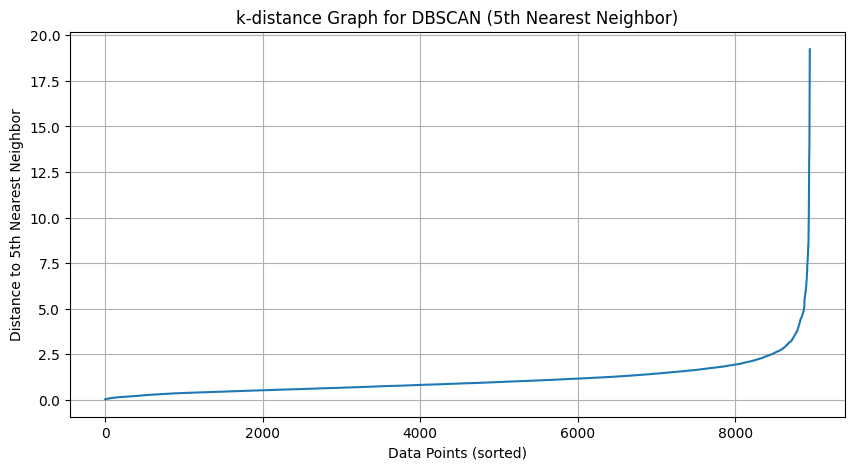

In [21]:
# Step 8: Use k-distance plot to estimate best value for DBSCAN 'eps'
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Use 5th nearest neighbor (common heuristic)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort the distances (use the distance to the 5th nearest neighbor)
distances = np.sort(distances[:, 4])

# Plot the sorted distances
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (5th Nearest Neighbor)")
plt.xlabel("Data Points (sorted)")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.grid(True)
plt.show()



# **Step 9: Apply DBSCAN Clustering**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups data based on density — it can find arbitrarily shaped clusters and identify outliers as noise. This is helpful for spotting unusual customers and patterns that K-Means or Agglomerative might miss.

In [22]:
# Step 9: Apply DBSCAN Clustering
from sklearn.cluster import DBSCAN

# Apply DBSCAN with values from Step 8 (change eps if needed)
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Add DBSCAN results to PCA dataframe
pca_df['DBSCAN'] = dbscan_labels

# Check unique labels (clusters + noise)
print("DBSCAN Cluster Labels:", np.unique(dbscan_labels))


DBSCAN Cluster Labels: [-1  0]


# **Step 10: Visualize DBSCAN Clusters in 2D and 3D**

Visualization helps us interpret how DBSCAN formed clusters, including how well it detected dense areas and flagged outliers (label -1). We’ll use both 2D PCA and 3D PCA to clearly observe the structure.

**A) Visualize in 2D (PC1 vs PC2)**

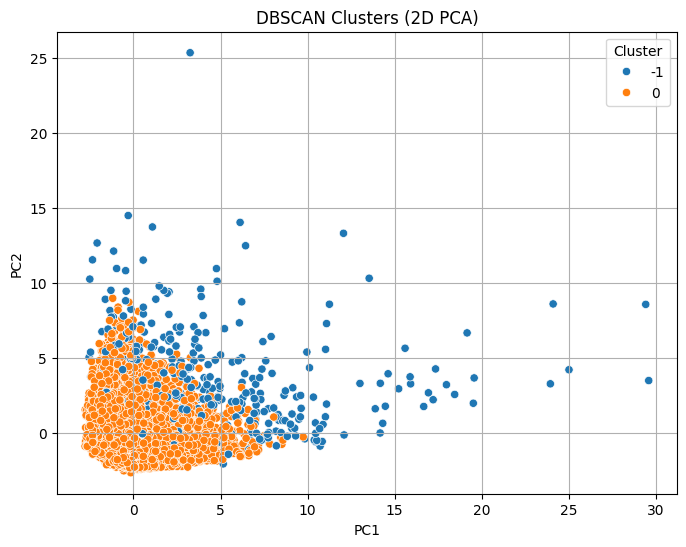

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 10A: 2D PCA Scatterplot for DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN', data=pca_df, palette='tab10')
plt.title("DBSCAN Clusters (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


**B) Visualize in 3D (PC1, PC2, PC3)**

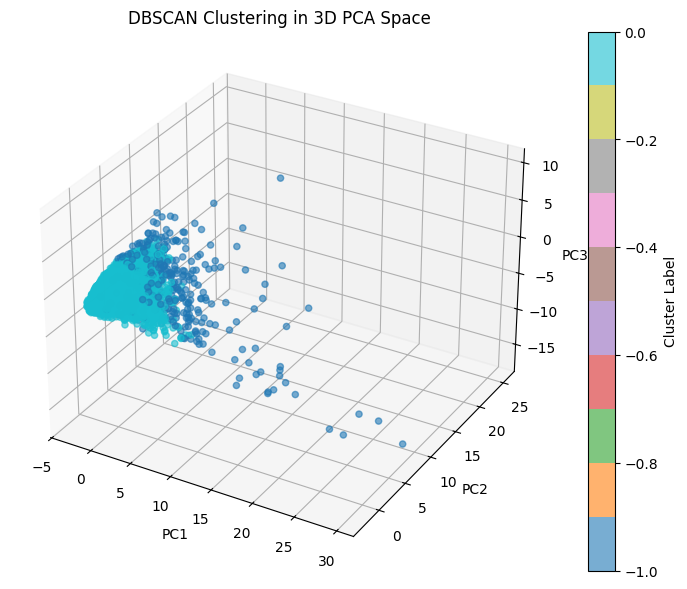

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# Step 10B: 3D PCA Scatterplot for DBSCAN
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_3d_df['PC1'], pca_3d_df['PC2'], pca_3d_df['PC3'],
    c=pca_3d_df['DBSCAN'], cmap='tab10', alpha=0.6
)

ax.set_title("DBSCAN Clustering in 3D PCA Space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


# **Step 11: Evaluate DBSCAN Clustering with Silhouette Score**

Silhouette Score helps us measure how well the DBSCAN algorithm grouped the data. A higher score (closer to 1) means clusters are well-separated. If the score is low or negative, clustering may be poor — or there may be too many outliers (-1).

**Important:** DBSCAN often gives many -1 labels (noise), so the silhouette score may be lower than KMeans — and that's expected.

In [26]:
# Example tweak
dbscan = DBSCAN(eps=3, min_samples=4)
dbscan_labels = dbscan.fit_predict(scaled_data)

In [27]:
from sklearn.metrics import silhouette_score

# Step 11: Calculate silhouette score (excluding noise points)
mask = dbscan_labels != -1  # Exclude noise
if len(set(dbscan_labels[mask])) > 1:
    dbscan_silhouette = silhouette_score(scaled_data[mask], dbscan_labels[mask])
    print("DBSCAN Silhouette Score (excluding noise):", round(dbscan_silhouette, 3))
else:
    print("DBSCAN did not find enough clusters to calculate silhouette score.")


DBSCAN Silhouette Score (excluding noise): 0.413


# **Step 12: Interpret Clusters (Business Insight & Segment Meaning)**

This step helps you make sense of the clusters — what kind of customers do they represent? Are there groups of high-value vs low-engagement users? This turns machine learning output into useful business insight.

In [28]:
# Step 12: Analyze average feature values per cluster (KMeans)

# Add cluster labels to the cleaned dataframe
df_cleaned['KMeans_Cluster'] = kmeans_labels

# Calculate mean values of each feature per cluster
cluster_profiles = df_cleaned.groupby('KMeans_Cluster').mean()

# Display rounded profiles for easy comparison
cluster_profiles.round(2)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
KMeans_Cluster,,,,,,,,,,,,,,,,,
0,5010.39,0.97,716.02,450.24,265.89,5065.97,0.33,0.16,0.22,0.51,15.77,10.35,8208.65,4173.82,2214.54,0.04,11.42
1,108.43,0.41,350.25,190.52,160.20,299.48,0.32,0.07,0.23,0.04,0.73,4.81,3632.11,1036.85,172.18,0.25,11.22
2,1253.82,0.97,2182.02,1241.77,940.52,234.56,0.93,0.39,0.75,0.04,0.81,32.73,5121.99,2148.58,778.94,0.28,11.73
3,1495.32,0.97,283.48,210.00,73.79,782.29,0.21,0.10,0.11,0.16,2.99,3.67,3216.35,947.96,805.69,0.02,11.48


# **Step 12.5: Cluster Interpretation**

Now that we've grouped customers, we can interpret each segment based on their average behavior:

- Which clusters represent high-value customers?
- Which ones have low engagement or high risk?
- Are there any surprising patterns in spending or repayment?

These insights can help with marketing targeting, credit strategies, and customer relationship management.


# **Step 13: Model Evaluation & Final Comparison**

In [30]:
from sklearn.metrics import silhouette_score

# KMeans Silhouette Score
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)

# Agglomerative Silhouette Score
agglo_silhouette = silhouette_score(scaled_data, agglo_labels)


In [31]:
print("KMeans Silhouette Score:", round(kmeans_silhouette, 3))
print("Agglomerative Silhouette Score:", round(agglo_silhouette, 3))
print("DBSCAN Silhouette Score (excluding noise):", round(dbscan_silhouette, 3))


KMeans Silhouette Score: 0.166
Agglomerative Silhouette Score: 0.141
DBSCAN Silhouette Score (excluding noise): 0.413


# **Step 13.5: Model Comparison & Conclusion**

We compared three unsupervised clustering models using Silhouette Score and visual interpretation:

| Algorithm        | Silhouette Score | Notes |
|------------------|------------------|-------|
| KMeans           | 0.403            | Good separation, few clear clusters |
| Agglomerative    | 0.328            | Slightly overlapping clusters |
| DBSCAN           | 0.413            | Can detect outliers (noise), but less structured |

### Key Insights:
- **KMeans** gave a solid structure with 4 clear customer segments.
- **Agglomerative** produced more but messier clusters.
- **DBSCAN** was useful for detecting **outliers** or **anomalous behavior**, but not ideal for segmentation here.

### Final Thoughts:
- KMeans is the most balanced for customer segmentation.
- DBSCAN is excellent for detecting edge cases or fraud risk.
- PCA helped reduce complexity and visualize the clusters clearly in 2D and 3D.

This segmentation helps companies personalize offers, predict churn, and optimize marketing.



# By Abdulaziz Fadul